# **Intel Image Classification**

In [15]:
!pip install kaggle

In [16]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [17]:
! cp kaggle.json ~/.kaggle/

In [18]:
! chmod 600 ~/.kaggle/kaggle.json

In [19]:
! kaggle datasets download puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
!unzip /content/intel-image-classification.zip -d /content/data

Archive:  /content/intel-image-classification.zip
replace /content/data/seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/seg_pred/seg_pred/10005.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Import Python Library

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2

**Data Understanding**

In [22]:
train_dir = 'data/seg_train/seg_train'
test_dir = 'data/seg_test/seg_test'
pred_dir = 'data/seg_pred/seg_pred'

In [23]:
classes = os.listdir(train_dir)
print(classes)

['street', 'buildings', 'glacier', 'sea', 'forest', 'mountain']


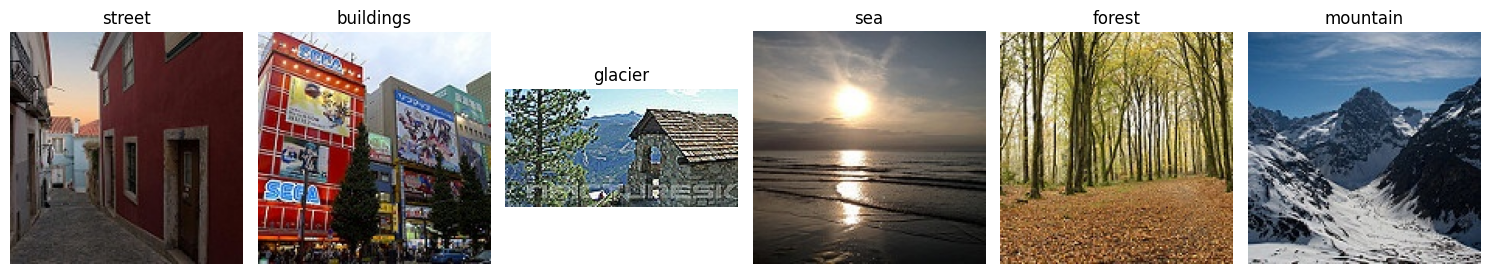

In [24]:
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
for idx, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if image_files:
        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img)
        axes[idx].set_title(class_name)
        axes[idx].axis('off')
    else:
        axes[idx].set_title(class_name + "\n(No images found)")
        axes[idx].axis('off')
plt.tight_layout()
plt.show()

**EDA**

Text(0, 0.5, 'Number of images')

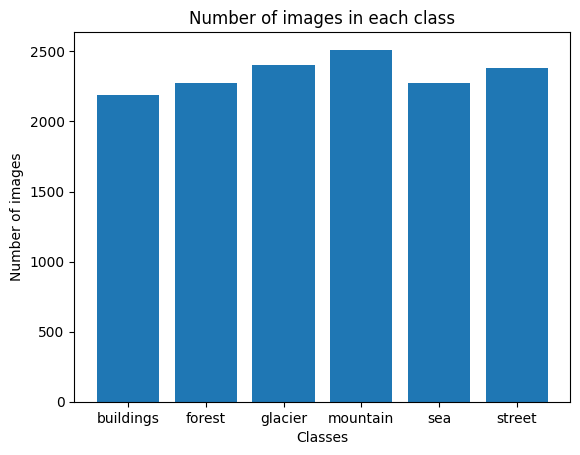

In [25]:
number_class = {
    'buildings': len(os.listdir(os.path.join(train_dir, 'buildings'))),
    'forest': len(os.listdir(os.path.join(train_dir, 'forest'))),
    'glacier': len(os.listdir(os.path.join(train_dir, 'glacier'))),
    'mountain': len(os.listdir(os.path.join(train_dir, 'mountain'))),
    'sea': len(os.listdir(os.path.join(train_dir, 'sea'))),
    'street': len(os.listdir(os.path.join(train_dir, 'street')))
}

plt.bar(number_class.keys(), number_class.values(), width = .8)
plt.title('Number of images in each class')
plt.xlabel('Classes')
plt.ylabel('Number of images')

In [26]:
height, width, channels = img.shape
print(f"Image dimensions: {height}x{width}, Channels: {channels}")

Image dimensions: 150x150, Channels: 3


**Modelling**

In [27]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=(height, width),
    batch_size=32,
    label_mode='categorical')
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(height, width),
    batch_size=32,
    label_mode='categorical')

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [28]:
image_class = train_set.class_names
print(image_class)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [29]:
model = tf.keras.Sequential()

In [30]:
import_model = tf.keras.applications.ResNet50(
    input_shape=(height, width, channels),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classes=len(image_class)
)
for layer in import_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [31]:
model.add(import_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(len(image_class), activation='softmax'))

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [37]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
history = model.fit(
train_set,
validation_data=test_set,
epochs=10
)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1416s 3s/step - accuracy: 0.8344 - loss: 0.4694 - val_accuracy: 0.8980 - val_loss: 0.2692
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1451s 3s/step - accuracy: 0.9197 - loss: 0.2208 - val_accuracy: 0.8880 - val_loss: 0.2879
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1410s 3s/step - accuracy: 0.9385 - loss: 0.1677 - val_accuracy: 0.9003 - val_loss: 0.2771
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1473s 3s/step - accuracy: 0.9483 - loss: 0.1320 - val_accuracy: 0.9080 - val_loss: 0.2661
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1441s 3s/step - accuracy: 0.9670 - loss: 0.0922 - val_accuracy: 0.9053 - val_loss: 0.2961
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1420s 3s/step - accuracy: 0.9760 - loss: 0.0721 - val_accuracy: 0.9047 - val_loss: 0.3004
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1463s 3s/step - accuracy: 0.9837 - loss: 0.0523 - val_accuracy: 0.9063 - val_loss: 0.3046
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1455s 3s/step - accuracy: 0.9867 - loss: 0.0434 - 

In [40]:
model.save("model.keras")